1. Import libraries & mount drive




In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from google.colab import drive
drive.mount('/content/drive')

sns.set_style("whitegrid")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Load datasets

In [19]:
df_dev = pd.read_csv('/content/drive/MyDrive/Dataset/immunization_developing_country.csv')

# Global dataset
df_glob = pd.read_csv('/content/drive/MyDrive/Dataset/immunization_global.csv')

# Drop unnecessary columns in global dataset
df_glob = df_glob.drop(columns=['unvaccinated', 'target'])

3. Fill missing values in developing dataset

In [20]:
# Fill missing coverage for developing dataset using median per country & vaccine
df_dev['coverage'] = df_dev.groupby(['country','vaccine'])['coverage'].transform(lambda x: x.fillna(x.median()))

# Add group labels
df_dev['group'] = 'Developing'
df_glob['group'] = 'Global'

4. Info, Missing Values, and Coverage Summary

In [21]:
print("Developing dataset info:")
df_dev.info()
print("\nGlobal dataset info:")
df_glob.info()

print("\nMissing values - Developing dataset:")
print(df_dev.isna().sum())
print("\nMissing values - Global dataset:")
print(df_glob.isna().sum())

# Summary statistics
print("\nCoverage statistics - Developing:")
print(df_dev['coverage'].describe())
print("\nCoverage statistics - Global:")
print(df_glob['coverage'].describe())

Developing dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34100 entries, 0 to 34099
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   unicef_region  34100 non-null  object 
 1   iso3           34100 non-null  object 
 2   country        34100 non-null  object 
 3   vaccine        34100 non-null  object 
 4   year           34100 non-null  int64  
 5   coverage       34100 non-null  float64
 6   group          34100 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.8+ MB

Global dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   region      482 non-null    object
 1   vaccine     482 non-null    object
 2   year        482 non-null    int64 
 3   coverage    482 non-null    int64 
 4   vaccinated  482 non-null    int64 
 5 

Top/bottom 10 countries analysis

In [22]:
country_mean = df_dev.groupby('country')['coverage'].mean().sort_values()
bottom_10 = country_mean.head(10).index
top_10 = country_mean.tail(10).index
selected_countries = list(bottom_10) + list(top_10)

print("Bottom 10 countries (Developing):")
display(country_mean.head(10))
print("Top 10 countries (Developing):")
display(country_mean.tail(10))

Bottom 10 countries (Developing):


,coverage
country,
Chad,44.628333
Central African Republic,44.649091
Somalia,45.588000
Papua New Guinea,45.607692
Nigeria,48.905333
Angola,50.874286
Guinea,51.767273
Afghanistan,55.129231
Yemen,56.886154


Top 10 countries (Developing):


,coverage
country,
Uruguay,95.041818
Malaysia,95.315000
Fiji,95.353846
Tunisia,95.436923
Mongolia,95.561667
China,95.720000
State Of Palestine,96.197143
Maldives,97.580000
Sri Lanka,97.592000


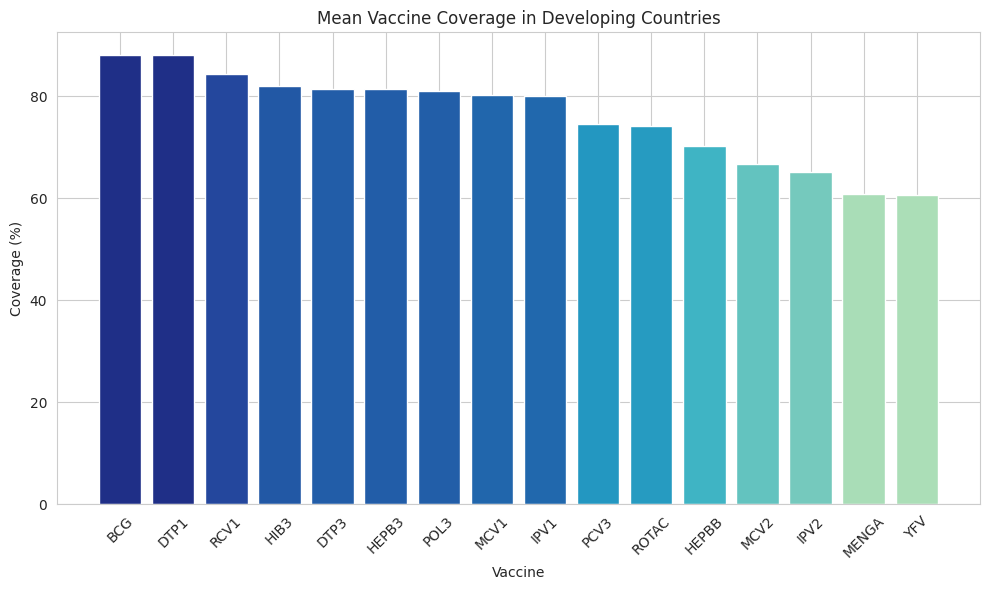

In [40]:
import matplotlib.cm as cm

# Mean coverage per vaccine (Developing countries only)
dev_vaccine_mean = (
    df_dev
    .groupby("vaccine")["coverage"]
    .mean()
    .sort_values(ascending=False)
)

# Normalize values (0 → lowest, 1 → highest)
norm = (dev_vaccine_mean - dev_vaccine_mean.min()) / (
    dev_vaccine_mean.max() - dev_vaccine_mean.min()
)

# Map normalized values to colormap
colors = cm.YlGnBu(0.3 + 0.6 * norm.values)

plt.figure(figsize=(10,6))
plt.bar(dev_vaccine_mean.index, dev_vaccine_mean.values, color=colors)
plt.title("Mean Vaccine Coverage in Developing Countries")
plt.ylabel("Coverage (%)")
plt.xlabel("Vaccine")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Heatmaps for top/bottom countries

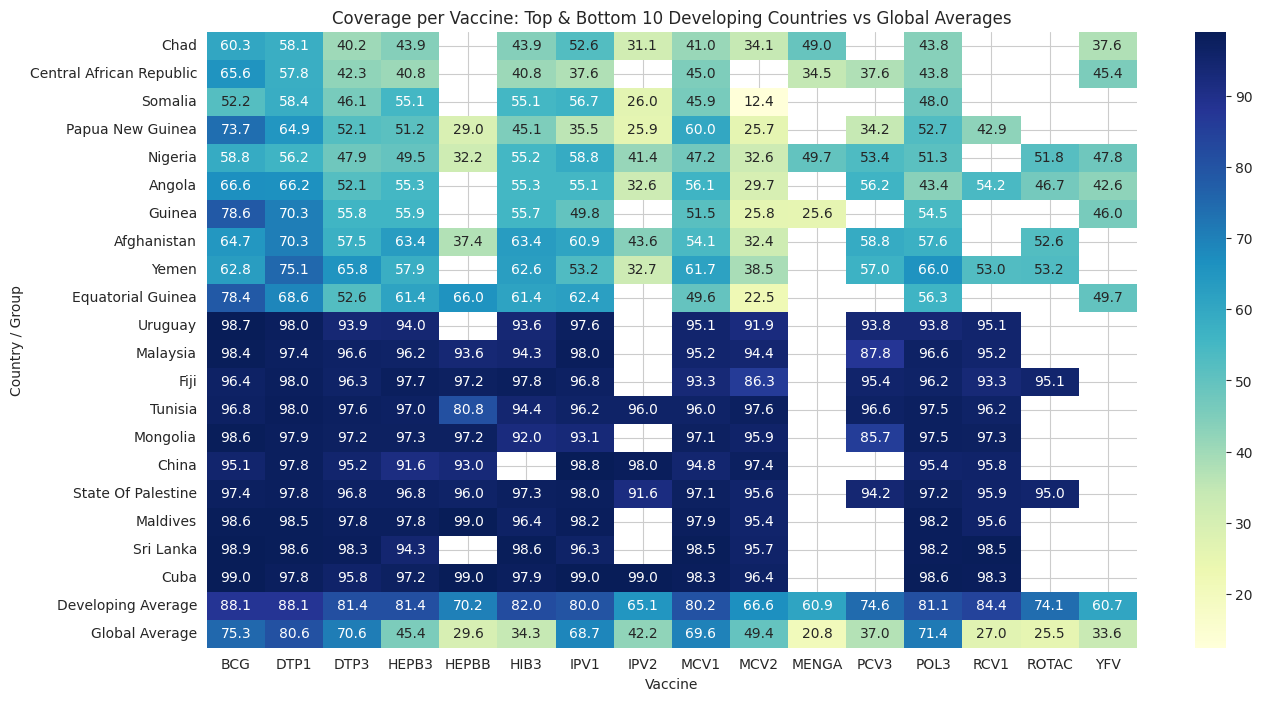

In [23]:
pivot_dev = df_dev.pivot_table(
    index='country',
    columns='vaccine',
    values='coverage',
    aggfunc='mean'
).loc[selected_countries]

# Add averages for reference
dev_avg_vaccine = df_dev.groupby('vaccine')['coverage'].mean()
glob_avg_vaccine = df_glob.groupby('vaccine')['coverage'].mean()
pivot_dev.loc['Developing Average'] = dev_avg_vaccine
pivot_dev.loc['Global Average'] = glob_avg_vaccine

# Heatmap: Top & Bottom Countries + Averages
plt.figure(figsize=(15,8))
sns.heatmap(pivot_dev, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Coverage per Vaccine: Top & Bottom 10 Developing Countries vs Global Averages")
plt.ylabel("Country / Group")
plt.xlabel("Vaccine")
plt.show()


Boxplot & vaccine-wise heatmaps comparing global vs developing

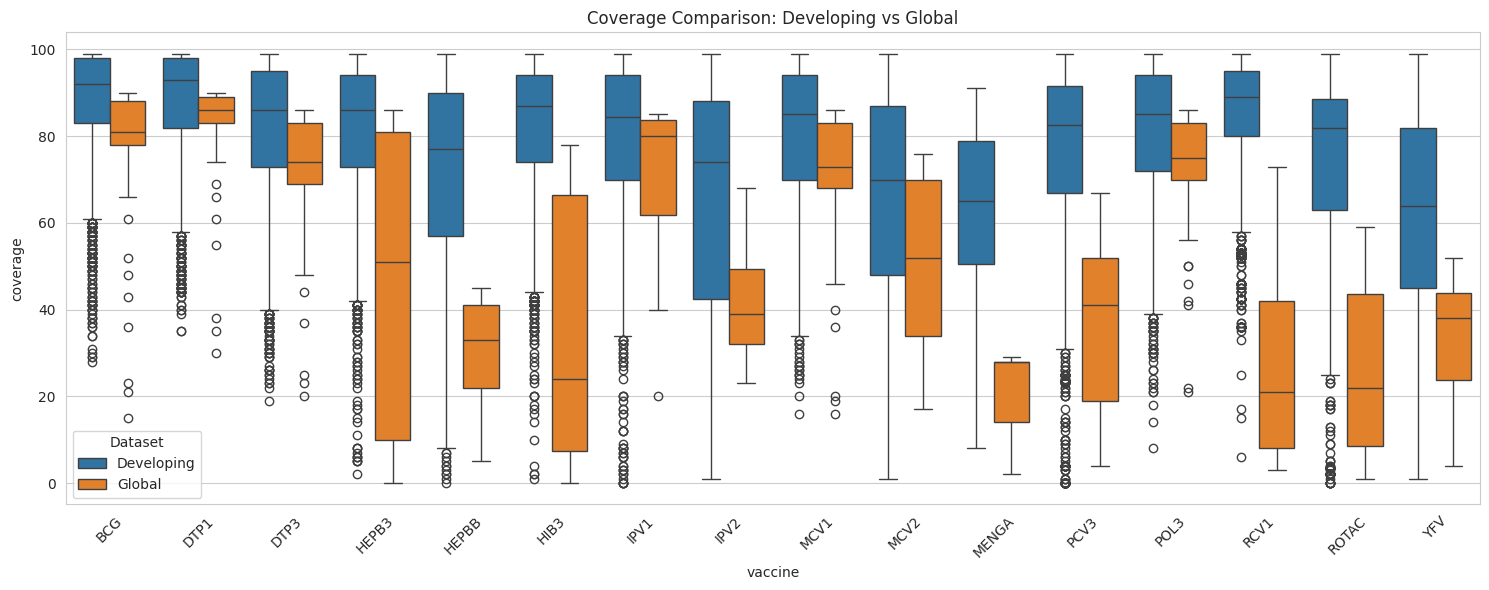

In [24]:
df_combined = pd.concat([df_dev, df_glob], ignore_index=True)

# Boxplot
plt.figure(figsize=(15,6))
sns.boxplot(
    data=df_combined,
    x='vaccine',
    y='coverage',
    hue='group'
)
plt.title("Coverage Comparison: Developing vs Global")
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

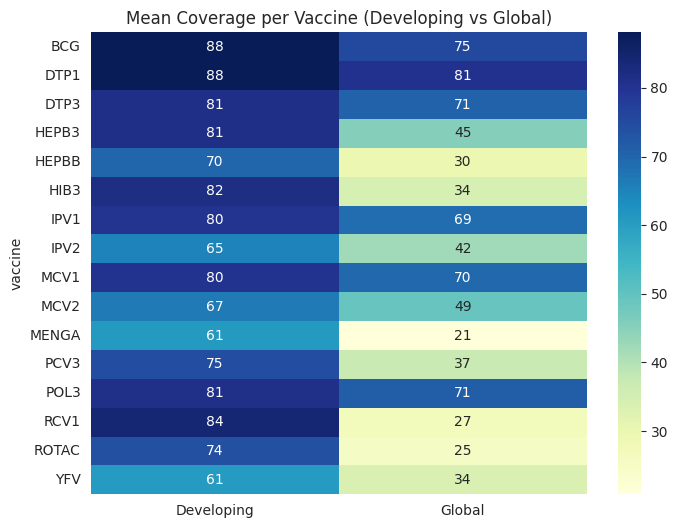

In [25]:
# Mean coverage per vaccine
vaccine_compare = pd.concat([
    df_dev.groupby('vaccine')['coverage'].mean(),
    df_glob.groupby('vaccine')['coverage'].mean()
], axis=1)
vaccine_compare.columns = ['Developing', 'Global']

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(vaccine_compare, annot=True, cmap="YlGnBu")
plt.title("Mean Coverage per Vaccine (Developing vs Global)")
plt.show()

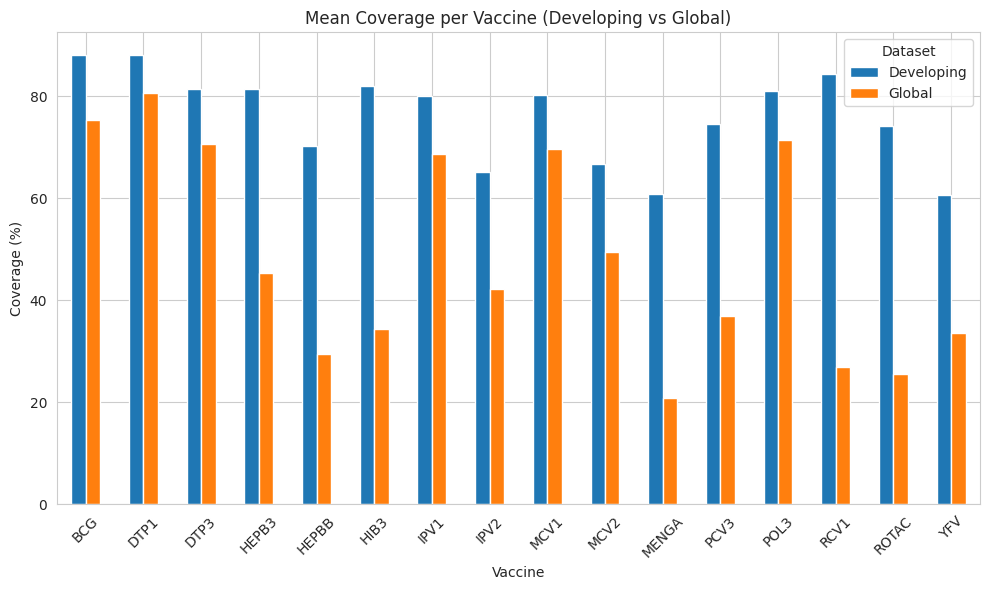

In [26]:
vaccine_compare.plot(kind='bar', figsize=(10,6))
plt.title("Mean Coverage per Vaccine (Developing vs Global)")
plt.ylabel("Coverage (%)")
plt.xlabel("Vaccine")
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


FacetGrid for vaccine trends in developing countries

<Figure size 2000x1200 with 0 Axes>

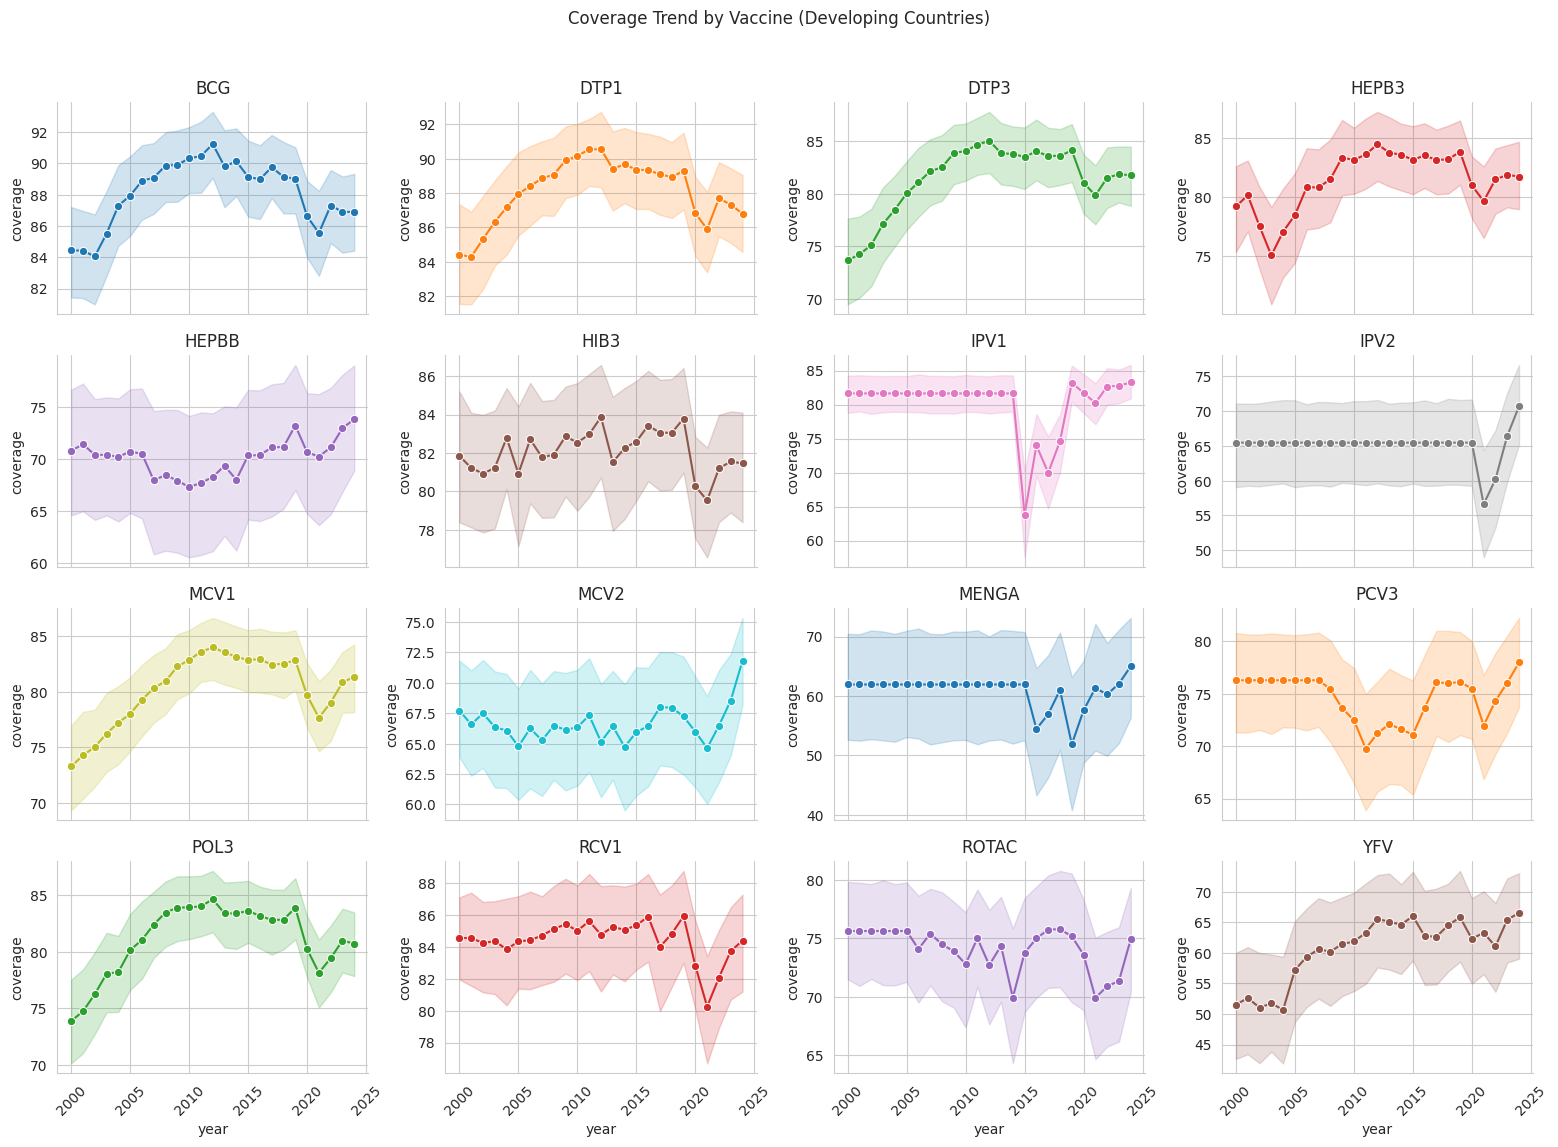

In [27]:
unique_vaccines = df_dev['vaccine'].unique()
palette = sns.color_palette("tab10", len(unique_vaccines))
color_map = dict(zip(unique_vaccines, palette))

plt.figure(figsize=(20,12))
g = sns.FacetGrid(
    df_dev,
    col="vaccine",
    col_wrap=4,
    height=2.8,
    aspect=1.4,
    sharey=False
)
for ax, (vaccine, data) in zip(g.axes.flatten(), df_dev.groupby("vaccine")):
    sns.lineplot(
        data=data,
        x="year",
        y="coverage",
        marker="o",
        color=color_map[vaccine],
        ax=ax
    )
    ax.set_title(vaccine)
    ax.tick_params(axis='x', labelrotation=45)
g.fig.suptitle("Coverage Trend by Vaccine (Developing Countries)", y=1.02)
plt.tight_layout()
plt.show()

FacetGrid for developing vs global trends (year>2000)

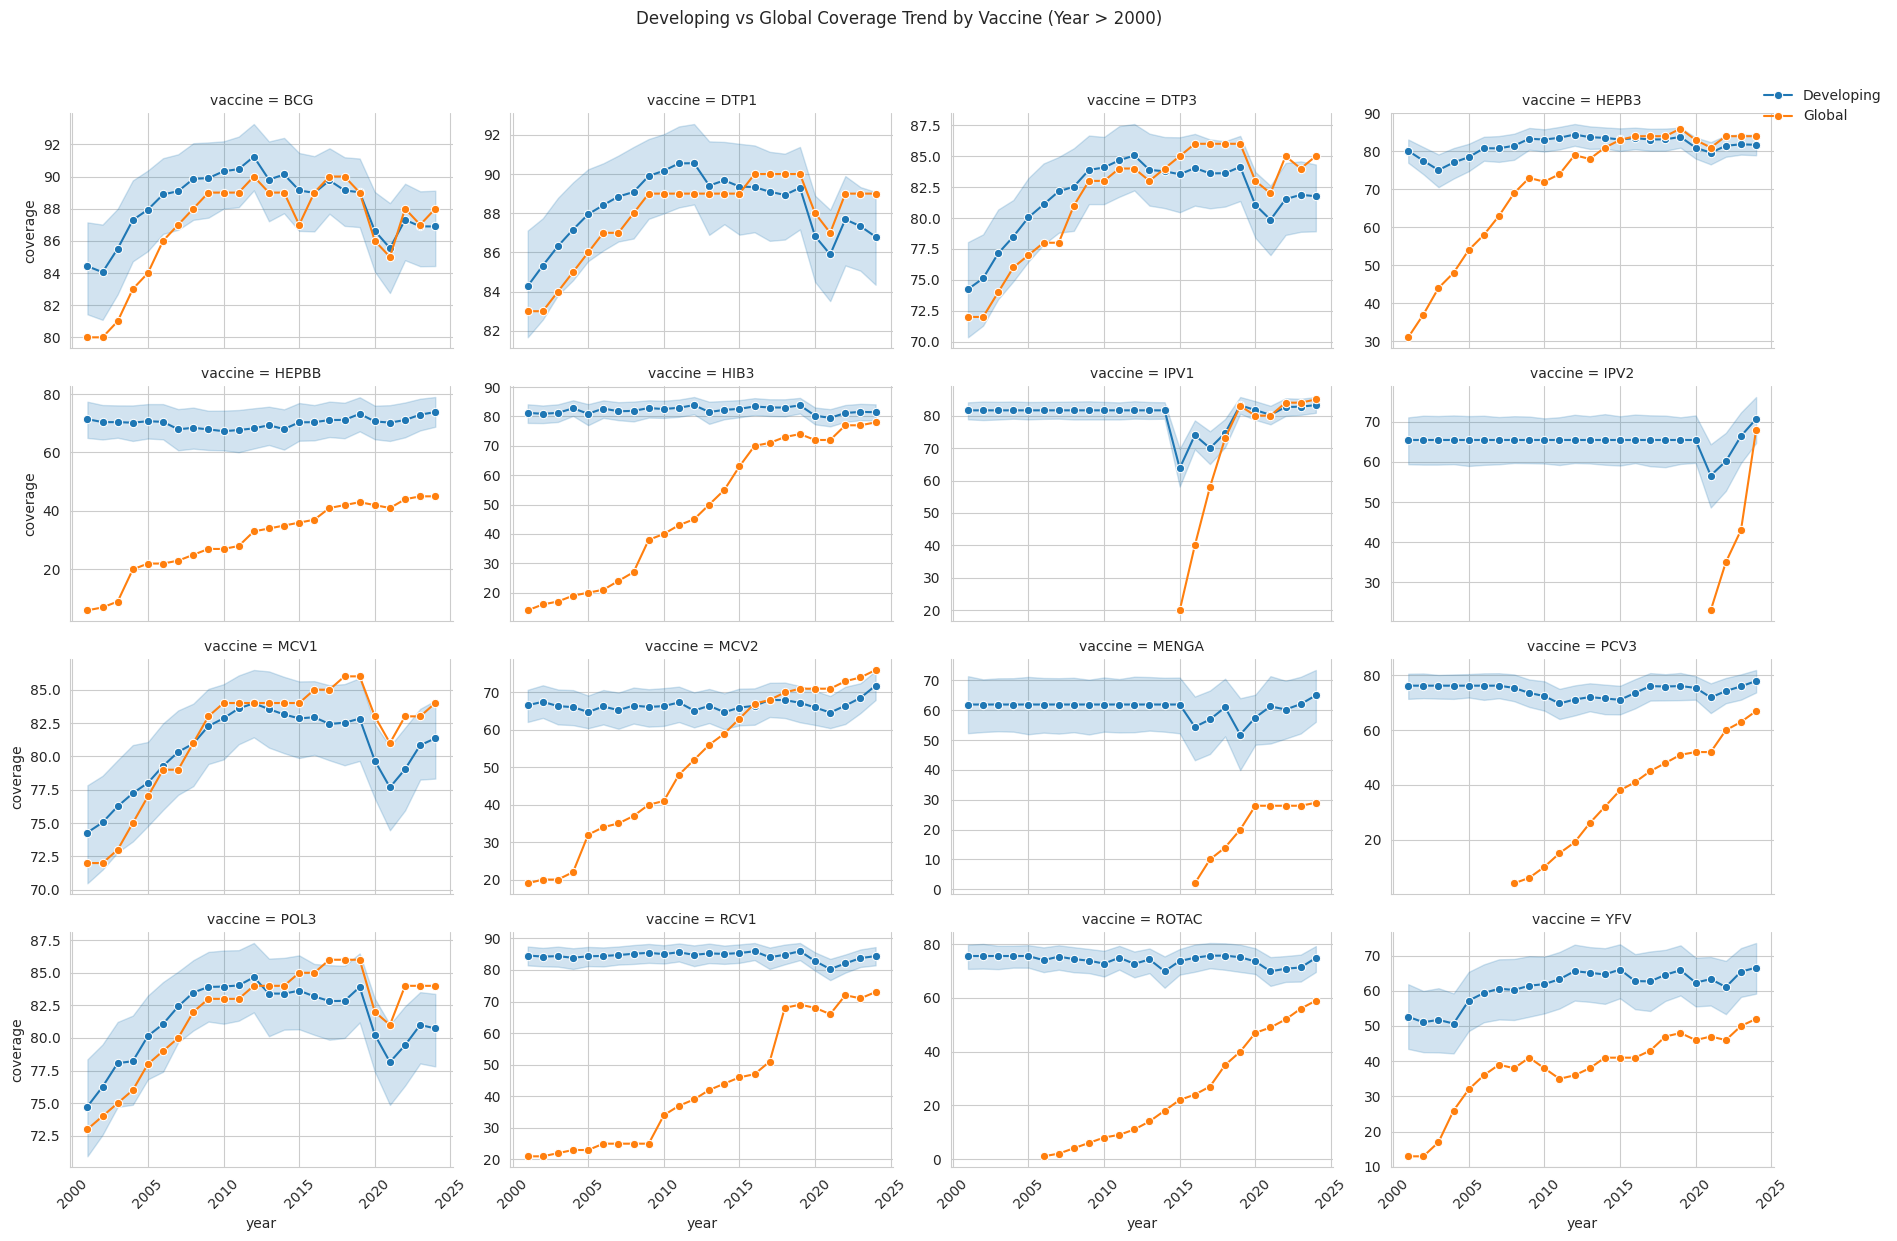

In [28]:
df_dev_recent = df_dev[df_dev['year'] > 2000].copy()
df_glob_recent = df_glob[df_glob['year'] > 2000].copy()
df_comb_recent = pd.concat([df_dev_recent, df_glob_recent], ignore_index=True)
df_comb_recent['dataset'] = df_comb_recent['group']

g = sns.FacetGrid(
    df_comb_recent,
    col="vaccine",
    col_wrap=4,
    height=3,
    aspect=1.4,
    sharey=False
)
g.map_dataframe(
    sns.lineplot,
    x="year",
    y="coverage",
    hue="dataset",
    marker="o"
)
g.add_legend(bbox_to_anchor=(1.05, 0.95))
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
g.fig.suptitle("Developing vs Global Coverage Trend by Vaccine (Year > 2000)", y=1.03)
plt.tight_layout()
plt.show()

Stats comparison

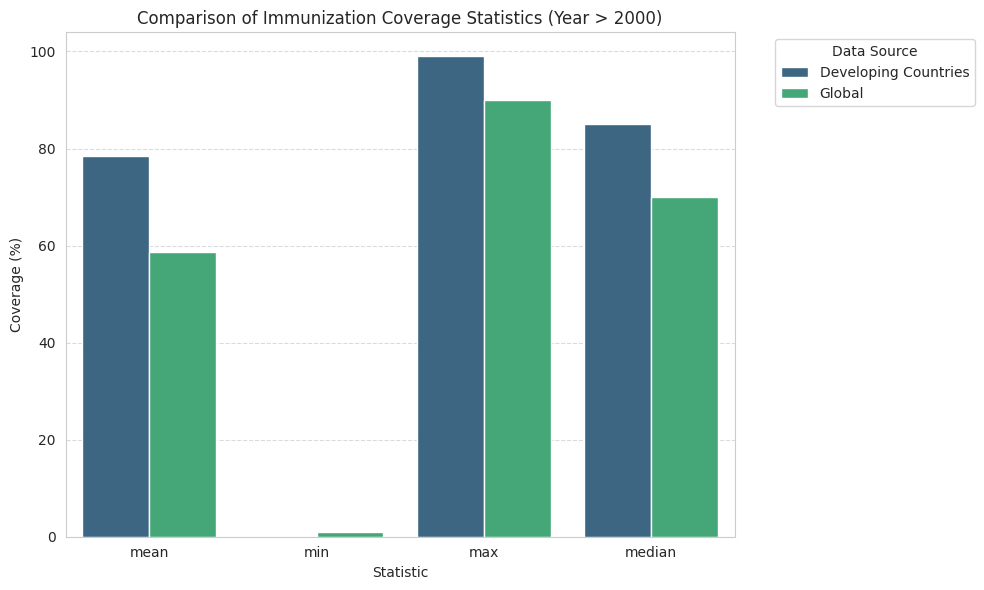

In [29]:
dev_stats = df_dev_recent['coverage'].agg(['mean', 'min', 'max', 'median']).reset_index()
dev_stats.columns = ['stat', 'coverage_dev']

glob_stats = df_glob_recent['coverage'].agg(['mean', 'min', 'max', 'median']).reset_index()
glob_stats.columns = ['stat', 'coverage_glob']

stats_comparison = dev_stats.join(glob_stats['coverage_glob'])
df_melted = stats_comparison.melt(id_vars='stat', var_name='data_source', value_name='coverage')
df_melted['data_source'] = df_melted['data_source'].replace({
    'coverage_dev': 'Developing Countries',
    'coverage_glob': 'Global'
})

plt.figure(figsize=(10,6))
sns.barplot(x='stat', y='coverage', hue='data_source', data=df_melted, palette='viridis')
plt.title('Comparison of Immunization Coverage Statistics (Year > 2000)')
plt.xlabel('Statistic')
plt.ylabel('Coverage (%)')
plt.legend(title='Data Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Distribution Analysis

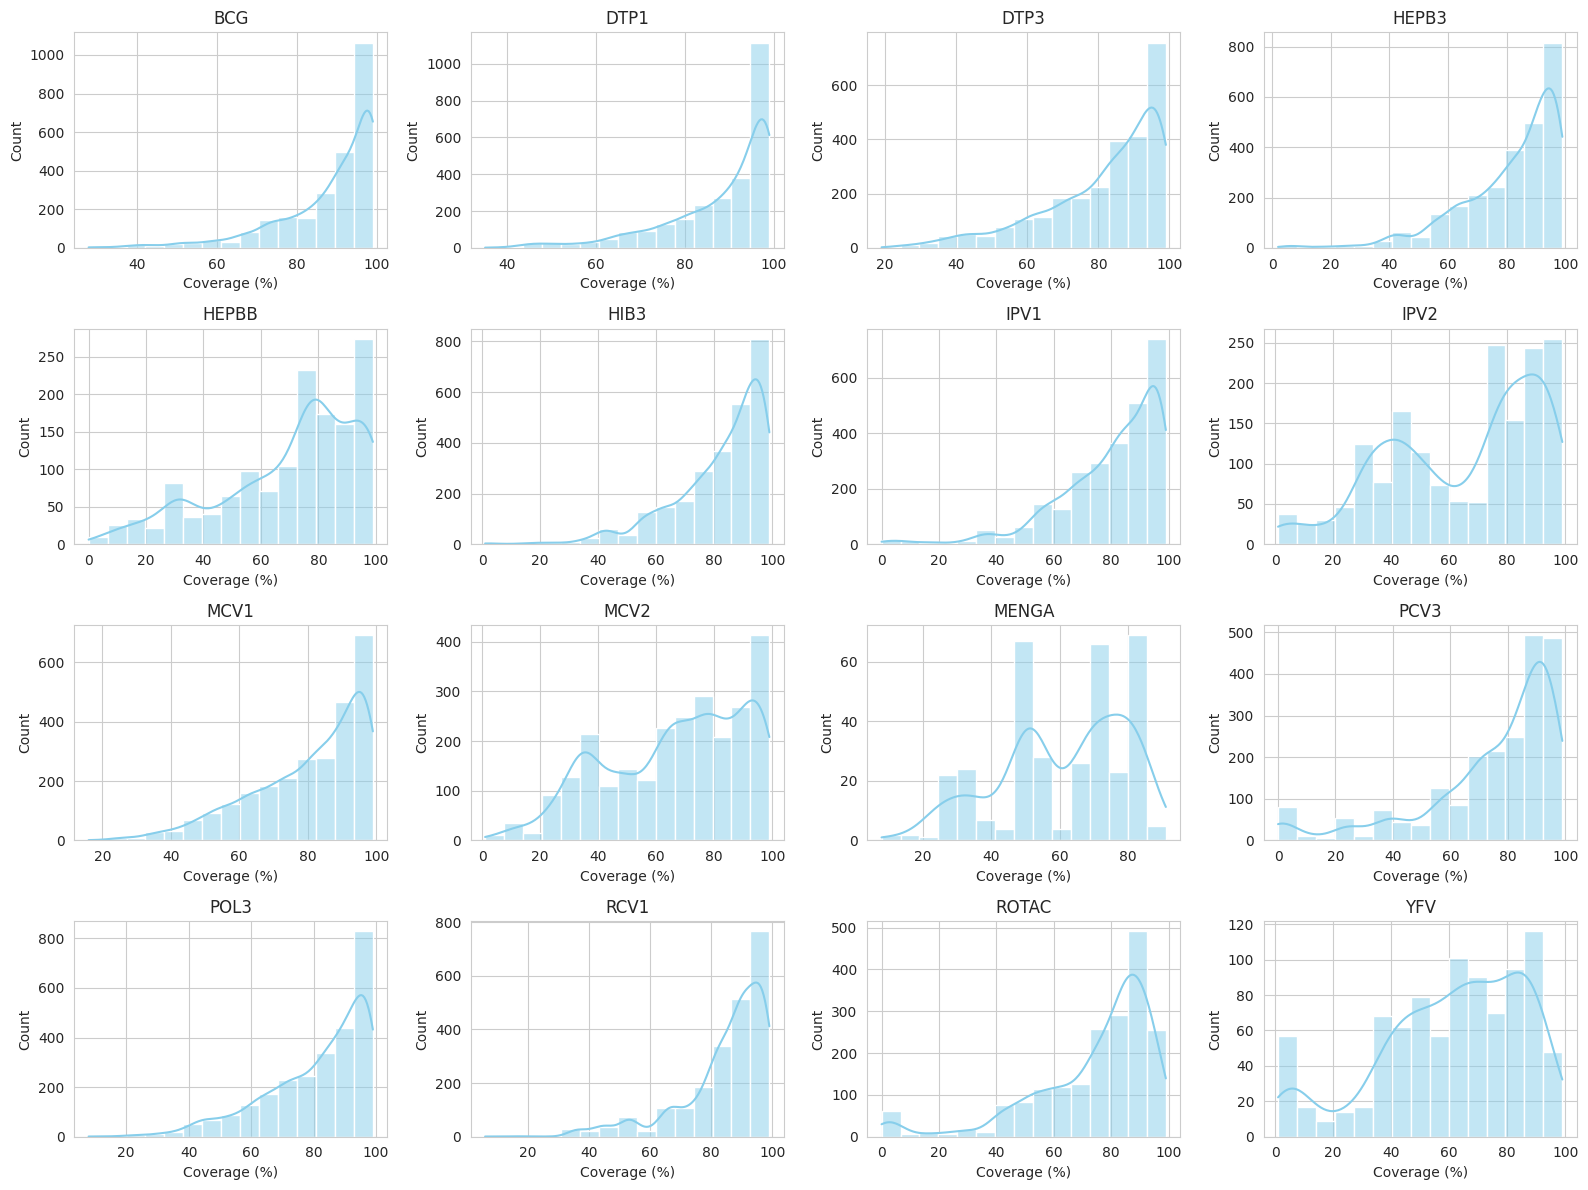

In [30]:
#Histogram / KDE per vaccine
unique_vaccines = df_dev['vaccine'].unique()
plt.figure(figsize=(16,12))

for i, vaccine in enumerate(unique_vaccines, 1):
    plt.subplot(4, 4, i)  # adjust grid based on number of vaccines
    sns.histplot(df_dev[df_dev['vaccine']==vaccine]['coverage'],
                 bins=15, kde=True, color='skyblue')
    plt.title(vaccine)
    plt.xlabel('Coverage (%)')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

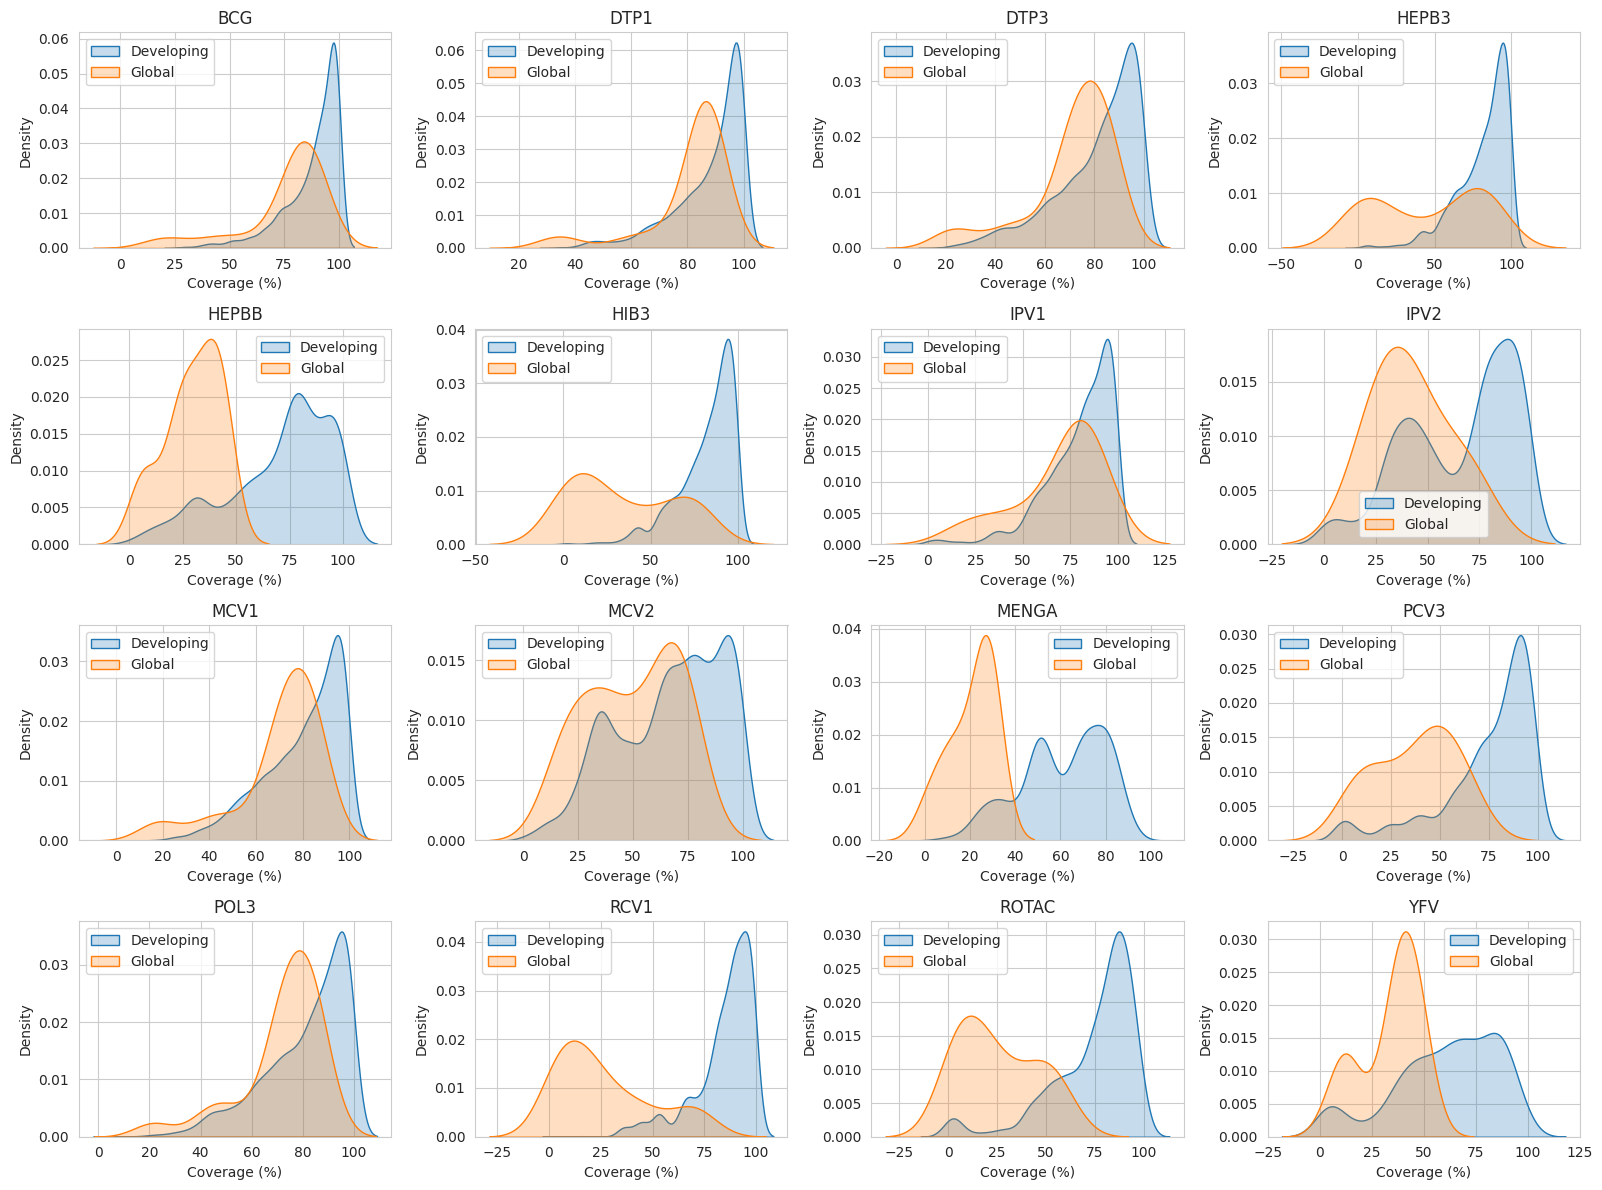

In [31]:
#Compare distributions between developing vs global
plt.figure(figsize=(16,12))

for i, vaccine in enumerate(unique_vaccines, 1):
    plt.subplot(4, 4, i)
    sns.kdeplot(df_dev[df_dev['vaccine']==vaccine]['coverage'], label='Developing', fill=True)
    sns.kdeplot(df_glob[df_glob['vaccine']==vaccine]['coverage'], label='Global', fill=True)
    plt.title(vaccine)
    plt.xlabel('Coverage (%)')
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()
